# <center> Проект 6. Сегментация клиентов онлайн-магазина</center>

## 1. Постановка задачи


В данном проекте вы решите настоящую бизнес-задачу в области маркетинга. Вам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. 

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [2]:
# Данный код нужен для подключения Google Disk, где хранился датафрейм
# при выполнении проекта в Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

# Mounted at /content/drive

In [4]:
data = pd.read_csv(
    "data/customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice CustomerID         Country  
0  12/1/2010 8:26       2.55      17850  United Kingdom  
1  12/1/2010 8:26       3.39      17850  United Kingdom  
2  12/1/2010 8:26       2.75      17850  United Kingdom  
3  12/1/2010 8:26       3.39      17850  United Kingdom  
4  12/1/2010 8:26       3.39      17850  United Kingdom

Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


### Задание 2.1
Сколько столбцов в данных кодируются числовыми типами (int/float)?

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


### Задание 2.2
Выберите столбцы, в которых есть хотя бы один пропуск:
* [ ] InvoiceNo
* [ ] StockCode
* [X] Description
* [X] CustomerID
* [ ] Country

In [6]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Задание 2.3
Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это.

Преобразуйте столбец InvoiceDate в формат datetime.
Укажите, за какой промежуток времени представлены данные:

* [X] 2010-12-01 to 2011-12-09
* [ ] 2011-12-01 to 2012-12-09
* [ ] 2010-01-01 to 2011-01-09
* [ ] 2020-12-01 to 2021-12-09

In [7]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print(data['InvoiceDate'].dt.date.min())
print(data['InvoiceDate'].dt.date.max())

2010-12-01
2011-12-09


### Посмотрим на основные описательные статистики, чтобы уже на этом этапе наметить план работ по обработке признаков ↓

### Задание 2.4

1) Каково максимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

2) Каково минимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

3) Сколько, согласно данным, стоит самый дешёвый товар (за исключением товаров с отрицательной стоимостью)?

In [8]:
print('Максимальное количество товаров в заказе:', data['Quantity'].max())

Максимальное количество товаров в заказе: 80995


In [9]:
print('Минимальное количество товаров в заказе:', data['Quantity'].min())

Минимальное количество товаров в заказе: -80995


In [10]:
print('Стоимость самого дешевого товара:', data['UnitPrice'][data['UnitPrice']>=0].min())

Стоимость самого дешевого товара: 0.0


### Пояснение
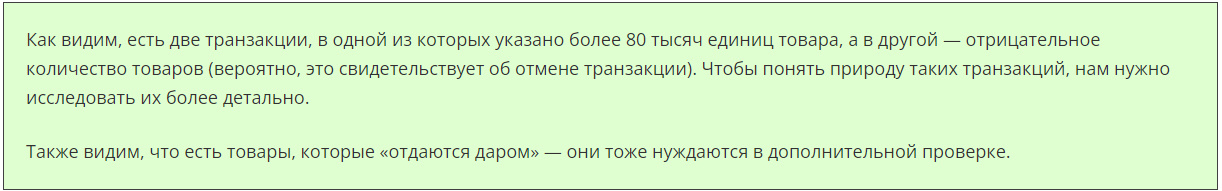

### Задание 2.5
1) Сколько уникальных клиентов покупали товары за период выгрузки датасета?

2) Сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну)?

3) Укажите идентификатор самого популярного товара (StockCode):
* 85123A
* 64812
* 51242
* 24151B


In [11]:
print('Количество уникальных клиентов:', data['CustomerID'].nunique())

Количество уникальных клиентов: 4372


In [12]:
print('Количество уникальных стран:', data['Country'].nunique()-1)

Количество уникальных стран: 37


In [13]:
print('Самый популярный товар:', data['StockCode'].value_counts().idxmax())

Самый популярный товар: 85123A


In [14]:
data['StockCode'].value_counts()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64

In [15]:
# Второй вариант получить ответы на вопросы:
data.describe(include='object')

InvoiceNo StockCode                         Description CustomerID  \
count     541909    541909                              540455     406829   
unique     25900      4070                                4223       4372   
top       573585    85123A  WHITE HANGING HEART T-LIGHT HOLDER      17841   
freq        1114      2313                                2369       7983   

               Country  
count           541909  
unique              38  
top     United Kingdom  
freq            495478

## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


### Задание 3.1
Начнем с пропусков. 

1) Сколько всего в таблице пропущенных значений?

2) Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.

Удалите строки, содержащие пропуски в этих столбцах. Сколько строк осталось в таблице?



**Python - *ISNA () и - NOTNA ()* - Функции для предварительной обработки данных** - https://pythobyte.com/isna-and-notna-python-bf369040/

In [16]:
print(f'всего в таблице пропущенных значений {data.isna().sum().sum()}')

#Удалите строки, содержащие пропуски в столбцах с идентификатором клиента
data = data[data['CustomerID'].notna()]
print(f'всего в таблице пропущенных значений после удаления пропусков {data.isna().sum().sum()}')
print(f'размер оставшейся таблицы {data.shape}')

всего в таблице пропущенных значений 136534
всего в таблице пропущенных значений после удаления пропусков 0
размер оставшейся таблицы (406829, 8)


In [ ]:
# print('Всего пропущенных значений:', data.isnull().sum().sum())
# data.dropna(inplace=True)
# print(f'После удаления пропусков в таблице осталось {data.shape[0]} строк.')

Всего пропущенных значений: 136534
После удаления пропусков в таблице осталось 406829 строк.

### Задание 3.2
Следом за пропусками проверим наличие дубликатов.

1) Сколько в таблице полностью дублирующихся записей?

2) Удалите дубликаты из таблицы. Сколько строк осталось?



In [17]:
print(f'в таблице полностью дублирующихся записей {data.duplicated().sum()}')

#Удалите дубликаты из таблицы
data = data.drop_duplicates()
print(f'всего в таблице полностью дублирующихся записе после удаления {data.duplicated().sum()}')
print(f'размер оставшейся таблицы {data.shape}')

в таблице полностью дублирующихся записей 5225
всего в таблице полностью дублирующихся записе после удаления 0
размер оставшейся таблицы (401604, 8)


In [18]:
# print(f'Найдено {data.duplicated().sum()} дубликатов.')
# data.drop_duplicates(inplace=True)
# print(f'После удаления дубликатов в таблице осталось {data.shape[0]} строк.')

Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [19]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice CustomerID         Country  
141 2010-12-01 09:41:00      27.50      14527  United Kingdom  
154 2010-12-01 09:49:00       4.65      15311  United Kingdom  
235 2010-12-01 10:24:00       1.65      17548  United Kingdom  
236 2010-12-01 10:24:00       0.29      17548  United Kingdom  
237 2010-12-01 10:24:00       0.29      17548  United Kingdom

### Задание 3.3
Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

Сколько транзакций из таблицы - **negative_quantity** - не содержат в номере заказа признак возврата?

In [20]:
# negative_quantity['InvoiceNo'].apply(lambda x: 'C' not in x).sum()

In [21]:
no_return_sign = negative_quantity[negative_quantity['InvoiceNo'].str.startswith('C') == False].shape[0]
print(f'Количество транзакций, которые не содержат признак возврата: {no_return_sign}.')

Количество транзакций, которые не содержат признак возврата: 0.


Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [22]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

del temp

In [23]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24

### Задание 3.4
Добавьте во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Сколько процентов заказов в таблице являются возвратами? Ответ приведите в виде целого числа.


In [24]:
nb_products_per_basket['Order Canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x.startswith('C') else 0)
cancels = int(round(nb_products_per_basket['Order Canceled'].value_counts(normalize=True)[1]*100,0))
print(f'{cancels}% заказов являются возвратами.')

16% заказов являются возвратами.


In [25]:
# nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if 'C' in x else 0)

# nb_products_per_basket['order_canceled'].value_counts(normalize=True)

Давайте поближе взглянем на отмененные заказы:


In [26]:
nb_products_per_basket[nb_products_per_basket['Order Canceled']==1].head()

CustomerID InvoiceNo  Number of products  Order Canceled
1       12346   C541433                   1               1
23      12352   C545329                   2               1
24      12352   C545330                   1               1
25      12352   C547388                   7               1
39      12359   C549955                   2               1

Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [27]:
data[data['CustomerID'] == '12346']

InvoiceNo StockCode                     Description  Quantity  \
61619    541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624   C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   

              InvoiceDate  UnitPrice CustomerID         Country  
61619 2011-01-18 10:01:00       1.04      12346  United Kingdom  
61624 2011-01-18 10:17:00       1.04      12346  United Kingdom

Итак, вот пример пары «заказ-отмена». Обратите внимание на столбцы StockCode, UnitPrice, CustomerID и Quantity, сравните их для двух транзакций. 

### Задание 3.5
Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

* Верна ли гипотеза?
* Да, верна



In [28]:
h_flag = True # флаг гипотезы: по умолчанию, она верна

for ind in negative_quantity.index:
    mask1 = data['StockCode'] == negative_quantity.loc[ind, 'StockCode']
    mask2 = data['CustomerID'] == negative_quantity.loc[ind, 'CustomerID']
    mask3 = data['Quantity'] == abs(negative_quantity.loc[ind, 'Quantity'])
    if data[mask1 & mask2 & mask3].shape[0] == 0:
        h_flag = False
        break

if h_flag:
    print('Гипотеза верна')
else:
    print('Гипотеза неверна')

Гипотеза неверна


Давайте приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [29]:
data[data['CustomerID'] == '14527'].head(5)

InvoiceNo StockCode                        Description  Quantity  \
141    C536379         D                           Discount        -1   
8963    537159     22112         CHOCOLATE HOT WATER BOTTLE         6   
8964    537159     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
8965    537159     21479      WHITE SKULL HOT WATER BOTTLE          1   
8966    537159     22114  HOT WATER BOTTLE TEA AND SYMPATHY         6   

             InvoiceDate  UnitPrice CustomerID         Country  
141  2010-12-01 09:41:00      27.50      14527  United Kingdom  
8963 2010-12-05 13:17:00       4.95      14527  United Kingdom  
8964 2010-12-05 13:17:00       4.95      14527  United Kingdom  
8965 2010-12-05 13:17:00       3.75      14527  United Kingdom  
8966 2010-12-05 13:17:00       3.95      14527  United Kingdom

Обратите внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров вы не найдёте. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

### Задание 3.6
Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Верна ли гипотеза?
* [ ] Да, верна
* [X] Нет, не верна 

In [30]:
h_flag = True # флаг гипотезы: по умолчанию, она верна

for ind in negative_quantity.index:
    if negative_quantity.loc[ind, 'StockCode'] == 'D':
        continue
    mask1 = data['StockCode'] == negative_quantity.loc[ind, 'StockCode']
    mask2 = data['CustomerID'] == negative_quantity.loc[ind, 'CustomerID']
    mask3 = data['Quantity'] == abs(negative_quantity.loc[ind, 'Quantity'])
    if data[mask1 & mask2 & mask3].shape[0] == 0:
        h_flag = False
        break

if h_flag:
    print('Гипотеза верна')
else:
    print('Гипотеза неверна')

Гипотеза неверна


Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [28]:
#data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

In [31]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

InvoiceNo StockCode                      Description  Quantity  \
154     C536383    35004C  SET OF 3 COLOURED  FLYING DUCKS        -1   
9200     537195    35004C  SET OF 3 COLOURED  FLYING DUCKS        12   
18196   C537805    35004C  SET OF 3 COLOURED  FLYING DUCKS        -1   
28630    538651    35004C  SET OF 3 COLOURED  FLYING DUCKS        12   
39381   C539640    35004C  SET OF 3 COLOURED  FLYING DUCKS        -3   
44157    540157    35004C  SET OF 3 COLOURED  FLYING DUCKS        12   
59542    541293    35004C  SET OF 3 COLOURED  FLYING DUCKS        12   
78333   C542866    35004C  SET OF 3 COLOURED  FLYING DUCKS        -2   

              InvoiceDate  UnitPrice CustomerID         Country  
154   2010-12-01 09:49:00       4.65      15311  United Kingdom  
9200  2010-12-05 13:55:00       4.65      15311  United Kingdom  
18196 2010-12-08 13:18:00       4.65      15311  United Kingdom  
28630 2010-12-13 15:07:00       4.65      15311  United Kingdom  
39381 2010-12-20 15:27:00       4.65      15311  United Kingdom  
44157 2011-01-05 11:41:00       4.65      15311  United Kingdom  
59542 2011-01-17 13:39:00       4.65      15311  United Kingdom  
78333 2011-02-01 12:14:00       4.65      15311  United Kingdom

* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Мы подготовили для вас функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


**Перебирать строки** - в фрейме данных Pandas **iterrows()** - https://dev-gang.ru/article/kak-perebirat-stroki-v-freime-dannyh-pandas-zfvujv90k0/

In [30]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
quantity_canceled

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
541904    0.0
541905    0.0
541906    0.0
541907    0.0
541908    0.0
Length: 401604, dtype: float64

In [33]:
# Данный код выполняется 11 минут в Google Colab!

#def get_quantity_canceled(data) -> pd.Series:
    """Функция рассчитывает количество возвращенного товара
    для каждой транзакции из входного датафрейма.

    Args:
        data (pd.DataFrame): датафрейм со всеми транзакциями

    Returns:
        pd.Series: объект Series с объемами возвратов
    """
    
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) &
                       (data['InvoiceDate'] < col['InvoiceDate']) &
                       (data['Quantity'] > 0)].copy()
        # Транзакция-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0):
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled
        elif (df_test.shape[0] == 1):
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1):
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']:
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break
    #return quantity_canceled

#data['QuantityCanceled'] = get_quantity_canceled(data)

### Задание 3.7
Подсчитайте суммарное количество отмененных товаров в столбце QuantityCanceled. 


In [34]:
#data['QuantityCanceled'].sum()

In [35]:
#data[data['QuantityCanceled']>0]['QuantityCanceled'].sum()

# 245266.0

In [1]:
#data['QuantityCanceled'] = quantity_canceled
#data['QuantityCanceled'].sum()

## Задание 3.8
Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалите из таблицы транзакции, в поле которых указано отрицательное количество товара.  
Сколько записей осталось?

In [37]:
data.drop(index=data[data['Quantity']<0].index, axis=0, inplace=True)
print(f'В датафрейме осталось {data.shape[0]} записи.')

В датафрейме осталось 392732 записи.


In [28]:
#data_cleaned = data.copy()
#data_cleaned['QuantityCanceled'] = quantity_canceled
#data_cleaned = data_cleaned[data_cleaned['Quantity'] > 0]
#data_cleaned.shape[0]

392732

Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


### Задание 3.9
С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

Подсказка: Поиск подстрок в столбце можно организовать с помощью str.contains(). В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'. Параметр regex установите в значение True.

1) Сколько уникальных специальных видов транзакций вам удалось найти?

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы. 

2) Сколько записей осталось?



In [29]:
#list_special_codes = data_cleaned[data_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
#print('Special codes: {}'.format(list_special_codes))

#for special_code in list_special_codes:
    #data_cleaned = data_cleaned[data_cleaned['StockCode']!= special_code]
#data_cleaned.shape

Special codes: ['POST' 'C2' 'M' 'BANK CHARGES' 'PADS' 'DOT']


(391183, 9)

In [ ]:
alpha = data['StockCode'].str.contains(pat='^[a-zA-Z]+', regex=True)
ind = alpha[alpha == True].index
print('Количество уникальных специальных видов транзакций:', len(data.loc[ind, 'StockCode'].unique()))
print('Вот их перечень:', list(data.loc[ind, 'StockCode'].unique()))

data.drop(index=ind, axis=0, inplace=True)
print(f'После удаления записей с этими кодами в датафрейме осталось {data.shape[0]} записи.')

del alpha

### Задание 3.10
Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 

1) В скольких транзакциях цена за единицу товара равна 0?

2) Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться. Удалите такие транзакции из таблицы. Сколько записей осталось?



In [30]:
print(f'В {data_cleaned[data_cleaned["UnitPrice"]==0].shape[0]} транзакциях цена за единицу товара равна 0')

data_сleaned = data_cleaned[data_cleaned['UnitPrice'] != 0]
data_сleaned.shape


# В 33 транзакциях цена за единицу товара равна 0
# (391150, 9)

В 33 транзакциях цена за единицу товара равна 0


(391150, 9)

In [ ]:
print('Количество транзакций с нулевой ценой за единицу равно:', data[data['UnitPrice'] == 0].shape[0])
data.drop(data[data['UnitPrice'] == 0].index, axis=0, inplace=True)
print(f'После удаления этих транзакций в датафрейме осталось {data.shape[0]} записей.')

In [31]:
# Создадим точку восстановления, чтобы можно было вернуться в любой момент

data_cleaned.to_csv('data/data_project6.csv')

# data_cleaned = pd.read_csv('data/data_project6.csv', index_col=0)

In [ ]:
# Сохраняем датафрейм, а также индекс в столбец True_index
#data.to_csv('/content/drive/MyDrive/Colab Notebooks/data/customer_segmentation_project_after_chapter_3.csv', index_label='True_index') # для Google Colab
#data.to_csv('data/customer_segmentation_project_after_chapter_3.csv', index_label='True_index') # для VSCode

# Загружаем датафрейм и обновляем индекс на прежний из столбца True_index
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/customer_segmentation_project_after_chapter_3.csv') # для Google Colab
#data = pd.read_csv('data/customer_segmentation_project_after_chapter_3.csv') # для VSCode
#data.set_index(keys='True_index', inplace=True)
#data.index.name = '' # удаляем название индекса
#data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']) # преобразуем столбец с датой, т.к. при сохранении формат теряется
#data.shape # проверяем загрузку датафрейма в переменную

Поздравляем, этап очистки данных завершён. Рекомендуем сохранить полученный результат в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.

## 4. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [2]:
data_cleaned = pd.read_csv('data/data_project6.csv', index_col=0)

### Задание 4.1
Для начала выясним, в каких странах живут клиенты.

Постройте график, отражающий количество клиентов в каждой из стран. Обратите внимание, что нам нужны именно уникальные клиенты.

В какой стране живёт наибольшее количество клиентов?

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


**- Как удалить повторяющиеся строки в Pandas DataFrame -**drop_duplicates()** - https://www.codecamp.ru/blog/pandas-drop-duplicates/; - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html

**- PANDASPandas DataFrame.aggregate() – функция агрегирования - Источник:** - https://pythonpip.ru/pandas/pandas-dataframe-aggregate-funktsiya-agregirovaniya

**- Основы Pandas №2 // Агрегация и группировка** - https://pythonru.com/uroki/osnovy-pandas-2-agregacija-i-gruppirovka

In [3]:
customer_country = data_cleaned[['Country','CustomerID']].drop_duplicates()
country_stats = customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)
#строим график
fig = px.choropleth(
    data_frame=country_stats, #датафрейм
    locations="Country", #столбец с локациями
    locationmode = "country names", #режим сопоставления локаций с базой plotly
    color="CustomerID", #от чего зависит цвет
    title='Count of customer per country', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='jet'#палитра цветов
)
#отображаем его
fig.show()

In [4]:
#United Kingdom несоизмеримо больше других стран, поэтому уберем ее
fig = px.bar(
    country_stats.iloc[1:,:],
    x='Country',
    y='CustomerID',
    color='Country',
    title='Number of orders per country without United Kingdom',
    height=500
)
fig.show()

In [7]:
data_cleaned.head()

df_choropleth = data_cleaned.groupby(by='Country', as_index=False)['CustomerID'].nunique()
df_choropleth.sort_values(by='CustomerID', ascending=False)

Country  CustomerID
35        United Kingdom        3917
14               Germany          94
13                France          87
30                 Spain          30
3                Belgium          25
32           Switzerland          21
26              Portugal          19
18                 Italy          14
12               Finland          12
1                Austria          11
24                Norway          10
23           Netherlands           9
0              Australia           9
9                Denmark           9
6        Channel Islands           9
7                 Cyprus           8
31                Sweden           8
19                 Japan           8
25                Poland           6
33                   USA           4
5                 Canada           4
36           Unspecified           4
15                Greece           4
10                  EIRE           3
17                Israel           3
22                 Malta           2
34  United Arab Emirates           2
2                Bahrain           2
8         Czech Republic           1
21             Lithuania           1
20               Lebanon           1
27                   RSA           1
28          Saudi Arabia           1
29             Singapore           1
16               Iceland           1
4                 Brazil           1
11    European Community           1

### Задание 4.2
Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов?

Постройте визуализацию и выделите топ-3 стран по количеству поступающих заказов.

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [5]:
invoice_country = data_cleaned.groupby(by=["Country"], as_index=False)["InvoiceNo"].count().sort_values(by='InvoiceNo', ascending=False)

fig = px.bar(
    invoice_country,
    x='Country',
    y='InvoiceNo',
    color='Country',
    title='Numbers of orders per country',
    height=500
)
fig.show()

In [99]:
df_choroplef = data_cleaned.groupby(by='Country', as_index=False)['StockCode'].count()
df_choroplef.sort_values(by='Country', ascending=False).head(3)

Country  StockCode
36           Unspecified        241
35        United Kingdom     348892
34  United Arab Emirates         67

In [100]:
# from urllib.request import urlopen
# import json
import plotly.express as px 

In [ ]:
########################################################### - ????
fig = px.choropleth(
    data_frame=df_choropleth, #DataFrame
    locations="Country", #столбец с локациями
    locationmode = "country names", #режим сопоставления локаций с базой Plotly
    color="StockCode", #от чего зависит цвет
    range_color=[0, 350000], #диапазон цвета
    title='Number of orders in countries', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='Reds' #палитра цветов
)

#отображаем график
fig.show() -- ????????????? - неработает зависает программа

### Задание 4.3
Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Чему равна средняя общая стоимость заказов? Ответ приведите в фунтах стерлингов и округлите до целого числа.

In [6]:
data_cleaned['TotalPrice'] = data_cleaned['UnitPrice'] * (data_cleaned['Quantity'] - data_cleaned['QuantityCanceled'])
print(f'Cредняя общая стоимость заказов равна {data_cleaned.TotalPrice.mean():.0f}£') 

Cредняя общая стоимость заказов равна 21£


In [7]:
data_tp = data_cleaned
data_tp['TotalPrice'] = data_tp['UnitPrice']*(data_tp['Quantity'] - data_tp['QuantityCanceled'])
round(data_tp['TotalPrice'].mean(),0)

# 21.0

21.0

### Задание 4.4

Постройте визуализацию и выделите топ-3 стран, клиенты из которых приносят компании больше всего выручки:
* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)

* A Верно.
* D Верно. Интересно, что Нидерланды находятся на шестом месте по количеству заказов, однако из-за того что эти заказы оптовые, по выручке Нидерланды находятся на втором месте.
* E Верно.

In [7]:
most_price_per_countries = data_cleaned.groupby(
    by=["Country"], 
    as_index=False
)["TotalPrice"].sum().sort_values(by='TotalPrice', ascending=False)

fig = px.bar(
    most_price_per_countries,
    x='Country',
    y='TotalPrice',
    color='Country',
    title='Total revenue per country', # Общий доход за страна - Общий доход по стране
    height=500
)
fig.show()

In [8]:
#United Kingdom несоизмеримо больше других стран, поэтому уберем ее
fig = px.bar(
    most_price_per_countries.iloc[1:,:],
    x='Country',
    y='TotalPrice',
    color='Country',
    title='Total revenue per country without United Kingdom',
    height=500
)
fig.show()

In [ ]:
df_choropleth = data_tp.groupby(by='Country', as_index=False)['TotalPrice'].sum()
df_choropleth.sort_values(by='TotalPrice', ascending=False).head(3)

	Country	        TotalPrice
35	United Kingdom	6797691.44
23	Netherlands	    283443.54
10	EIRE	        247074.57

In [ ]:
fig = px.choropleth(
    data_frame=df_choropleth, #DataFrame
    locations="Country", #столбец с локациями
    locationmode = "country names", #режим сопоставления локаций с базой Plotly
    color="TotalPrice", #от чего зависит цвет
    range_color=[0, 7e6], #диапазон цвета
    title='Revenue in countries', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='Reds' #палитра цветов
)

#отображаем график
fig.show()

Теперь займёмся временными характеристиками.


### Задание 4.5
Добавьте в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Постройте визуализацию, отражающую распределение суммарной выручки от заказов по месяцам. Укажите номер самого прибыльного для компании месяца. Предположите, почему так происходит.

In [9]:
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])
data_cleaned['InvoiceMonth'] = data_cleaned['InvoiceDate'].dt.month
data_cleaned['InvoiceWeekday'] = data_cleaned['InvoiceDate'].dt.day_name()
data_cleaned['InvoiceHour'] = data_cleaned['InvoiceDate'].dt.hour

In [10]:
revenue_per_month = data_cleaned.groupby(
    by=["InvoiceMonth"], 
    as_index=False
)["TotalPrice"].sum().sort_values(by='TotalPrice', ascending=False)

fig = px.bar(
    revenue_per_month,
    x='InvoiceMonth',
    y='TotalPrice',
    color='InvoiceMonth',
    title='Total revenue per month'
)
fig.show()

Действительно, это ноябрь. Такой результат объясняется довольно просто: ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как мы анализируем данные магазина подарков, то совсем не удивительно, что мы видим максимальный рост продаж в преддверии этих праздников.

In [ ]:
data_dt = data_tp
data_dt['InvoiceDate'] = pd.to_datetime(data_dt['InvoiceDate'])
data_dt['Month'] = data_dt['InvoiceDate'].dt.month_name()
data_dt['Day of the week'] = data_dt['InvoiceDate'].dt.day_name()
data_dt['Hour'] = data_dt['InvoiceDate'].dt.hour
# data_dt

df_bar = data_dt.groupby(by='Month', as_index=False)['TotalPrice'].sum().round(0)
df_bar.sort_values(by='TotalPrice', ascending=False)

#####################################################
	Month	TotalPrice
9	November	1119642.0
10	October	967436.0
11	September	928554.0
2	December	894127.0
8	May	647404.0
1	August	614704.0
6	June	601238.0
5	July	581019.0
7	March	571941.0
4	January	453561.0
0	April	447923.0
3	February	436043.0
______________________________________________________________________________________________
#строим график
fig = px.bar(
    data_frame=df_bar, # датафрейм
    x="Month", 
    y="TotalPrice", 
    color='Month', # расцветка в зависимости от месяца
    text = 'TotalPrice', # текст на столбцах
    orientation='v', # ориентация графика
    height=500, 
    width=1200, 
    title='Выручка в месяц' # заголовок графика
)
fig.update_layout(xaxis={'categoryorder':'total descending'}) # сотрируем по убыванию

fig.show() # отображаем его

### Задание 4.6
Постройте визуализацию количества заказов для каждого дня недели. Укажите день недели, в который, согласно данным, не совершено ни одного заказа:
* Понедельник
* Вторник
* Среда
* Четверг
* Пятница
* Суббота ---- 
* Воскресенье

In [11]:
invoice_per_day = data_cleaned.groupby(
    by=["InvoiceWeekday"], 
    as_index=False
)["InvoiceNo"].count().sort_values(by='InvoiceNo', ascending=False)

fig = px.bar(
    invoice_per_day,
    x='InvoiceWeekday',
    y='InvoiceNo',
    color='InvoiceWeekday',
    title='Number of orders per weekday'
)
fig.show()

### Действительно, согласно данным, нет ни одной транзакции, совершённой в субботу, что довольно странно. Возможно, суббота является выходным днём и транзакции в этот день не совершаются, а может быть, это ошибка в данных.

In [ ]:
df_bar = data_tp.groupby(by='Day of the week', as_index=False)['StockCode'].count()
# df_bar['StockCode'] = df_bar['StockCode'].div(52,1429).round(0)
df_bar['StockCode'] = df_bar['StockCode']
df_bar.sort_values(by = 'StockCode', ascending=False)

Day of the week	StockCode
3	Thursday	78904
5	Wednesday	67769
4	Tuesday	65491
1	Monday	63963
2	Sunday	61084
0	Friday	53939

In [ ]:
#строим график
fig = px.bar(
    data_frame=df_bar, #датафрейм
    x="Day of the week", #ось x
    y="StockCode", #ось y
    color='Day of the week', #расцветка в зависимости от страны
    text = 'StockCode', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1200, #ширина
    title='Number of orders by day of the week' #заголовок
)
fig.update_layout(xaxis={'categoryorder':'total descending'}) # сотрируем по убыванию
#отображаем его
fig.show()

### Задание 4.7
Выделите дату из признака времени совершения транзакции.
Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

Постройте визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

Выберите верные утверждения:
* A - Больше всего заказов совершается в дневное время в интервале от 18 до 20 часов
* B - Больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов
* C - Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают 
* D - Заказы поступают во все периоды дня


* B Верно.
* C Верно.

In [12]:
data_cleaned['Date'] = data_cleaned['InvoiceDate'].dt.date
count_invoice_per_date_hour = data_cleaned.groupby(
    by=['Date', "InvoiceHour"], 
    as_index=False
)["InvoiceNo"].count()
mean_count_invoice_per_hour = count_invoice_per_date_hour.groupby('InvoiceHour', as_index=False).mean()
fig = px.bar(
    mean_count_invoice_per_hour,
    x='InvoiceHour',
    y='InvoiceNo',
    title='Number of orders per hour',
    height=500
)
fig.show()

In [ ]:
data_dt['Date'] = data_tp['InvoiceDate'].dt.date
# data_dt
df_bar_47 = data_dt.groupby(by=['Date', 'Hour'], as_index=False)['StockCode'].count()
df_bar_47 = df_bar_47.groupby(by=['Hour'], as_index=False)['StockCode'].mean().round(0)
df_bar_47.sort_values(by = 'StockCode', ascending=False)

In [ ]:
#строим график
fig = px.bar(
    data_frame=df_bar_47, #датафрейм
    x="Hour",
    y="StockCode", 
    color='StockCode', # расцветка в зависимости от StockCode
    text = 'StockCode', # текст на столбцах
    orientation='v', # ориентация графика
    height=500, 
    width=1200, 
    title='Number of orders by hour' #заголовок
)
# fig.update_layout(xaxis={'categoryorder':'total descending'}) # сотрируем по убыванию
#отображаем его
fig.show()

## 5. RFM-сегментация клиентов: часть 1

Брошенная корзина. Как настроить продающую цепочку писем - https://sendpulse.com/ru/blog/how-to-do-rfm-analysishttps://sendpulse.com/ru/blog/how-to-do-rfm-analysis 

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


**Суть RFM-анализа -** https://sendpulse.com/ru/blog/how-to-do-rfm-analysis -- состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

### Задание 5.1

Итак, приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

1) Сколько клиентов совершили покупку более 200 дней назад?

2) Сколько заказов в среднем делает клиент (за представленный годовой период)? Ответ округлите до целого числа.

3) Чему равна общая сумма денег, которую потратил клиент с идентификатором 12360? Ответ приведите в фунтах стерлингов и округлите до целого числа.

In [13]:
from datetime import datetime, date, time

In [14]:
now = pd.to_datetime('2011-12-10')
custom_aggregation = {
    'InvoiceDate':  lambda x: (now - x.max()).days,
    'InvoiceNo': lambda x: len(x.unique()),
    'TotalPrice': lambda x: x.sum(),
}

rfm_table = data_cleaned.groupby('CustomerID').agg(custom_aggregation)

rfm_table = rfm_table.rename(
    columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary', 'TotalQuantity': 'MeanQuantity'}
)
rfm_table.head()

Recency  Frequency  Monetary
CustomerID                              
12346           325          1      0.00
12347             2          7   4310.00
12348            75          4   1437.24
12349            18          1   1457.55
12350           310          1    294.40

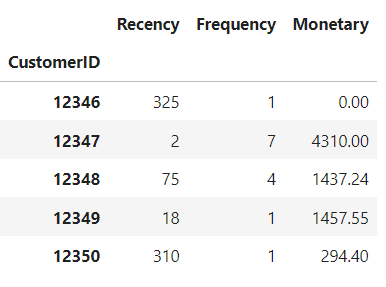

In [25]:
# код не работает ###############################
# ________________________________________________________
print(rfm_table[rfm_table['Recency'] > 200].shape[0])
print(round(rfm_table['Frequency'].mean(), 0))
# print(round(rfm_table.loc['12360']['Monetar'], 2))

# 743
# 4.0
# 2302

743
4.0


In [22]:
from datetime import datetime, date, time
now = datetime(2011, 12, 10)
custom_aggregation = {
    'InvoiceDate':  lambda x: (now - x.max()).days,
    'InvoiceNo': lambda x: len(x.unique()),
    'TotalPrice': lambda x: x.sum(),
}
rfm_table = data_cleaned.groupby(by='CustomerID')[['InvoiceDate', 'InvoiceNo', 'TotalPrice']].agg(custom_aggregation)
rfm_table = rfm_table.rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalPrice':'Monetary'})
rfm_table

Recency  Frequency  Monetary
CustomerID                              
12346           325          1      0.00
12347             2          7   4310.00
12348            75          4   1437.24
12349            18          1   1457.55
12350           310          1    294.40
...             ...        ...       ...
18280           277          1    180.60
18281           180          1     80.82
18282             7          2    176.60
18283             3         16   2039.58
18287            42          3   1837.28

[4335 rows x 3 columns]

In [23]:
rfm_table[rfm_table['Recency'] > 200].count()

Recency      743
Frequency    743
Monetary     743
dtype: int64

In [24]:
# Moto

round(rfm_table['Frequency'].mean(), 0)

4.0

In [ ]:
# - код не работает ###############################

rfm_table.loc[['12360']]

Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

**- *Шпаргалка по визуализации данных в Python с помощью - Plotly* -** https://habr.com/ru/articles/502958/

**- *Добавление следов* .**
Новые трассы могут быть добавлены к фигуре графического объекта с помощью - **add_trace()метода.** -  Этот метод принимает трассировку графического объекта **(экземпляр go.Scatter, go.Barи т. д.)**- и добавляет ее к фигуре. Это позволяет начать с пустой фигуры и последовательно добавлять к ней трассы. -- **Метод append_trace()** -делает то же самое, но - **не возвращает цифру.** - https://plotly.com/python/creating-and-updating-figures/

In [26]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
# fig.write_html('plotly/boxplot_1.html')
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


### Задание 5.2
Удалите из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 

Данные о скольких клиентах у вас остались в RFM-таблице?


In [27]:
# utliers - ?
utliers = rfm_table[
    (rfm_table['Frequency'] > rfm_table['Frequency'].quantile(0.95)) | 
    (rfm_table['Monetary'] > rfm_table['Monetary'].quantile(0.95))
]

rfm_table_cleaned = rfm_table.drop(outliers.index)
rfm_table_cleaned.shape[0]

4045

In [44]:
freq_95 = rfm_table['Frequency'].quantile(q=0.95)
mon_95 = rfm_table['Monetary'].quantile(q=0.95)
drop_data = rfm_table[(rfm_table['Frequency'] > freq_95) | (rfm_table['Monetary'] > mon_95)]
rfm_table_cleaned = rfm_table.drop(drop_data.index, axis=0)
rfm_table_cleaned

Recency  Frequency  Monetary
CustomerID                              
12346           325          1      0.00
12347             2          7   4310.00
12348            75          4   1437.24
12349            18          1   1457.55
12350           310          1    294.40
...             ...        ...       ...
18278            73          1    173.90
18280           277          1    180.60
18281           180          1     80.82
18282             7          2    176.60
18287            42          3   1837.28

[4045 rows x 3 columns]

После удаления выбросов у вас должны получиться следующие коробчатые диаграммы:


In [28]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
# fig.write_html('plotly/boxplot_2.html')
fig.show()

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


In [ ]:
# Код с учебного материала не работает
###################################################################################

boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_2.html')
fig.show()

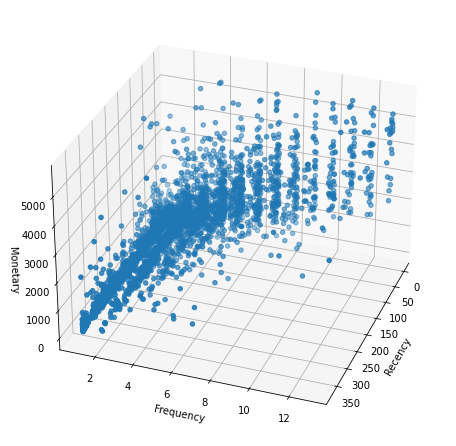

In [30]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');

Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.


### Задание 5.3
Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Давайте для удобства обернём эти шаги по предобработке данных в pipeline.

Создайте pipeline, в котором будут следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.

Обучите ваш pipeline на RFM-таблице, очищенной от выбросов, и примените к ней трансформацию.

Какую долю дисперсии исходных данных объясняет первая главная компонента? Ответ округлите до двух знаков после точки-разделителя.



In [31]:
# preprocessing - предварительная обработка
# dimension - размерность; 
# decomposiition - разложение
# explained_variance_ratio_ - https://stepik.org/lesson/384632/step/6

pipeline_preprocessing = pipeline.Pipeline(
    steps=[
        ('scaler', preprocessing.StandardScaler()),
        ('dimension', decomposition.PCA(n_components=2))
    ]
)
rfm_table_processed = pipeline_preprocessing.fit_transform(rfm_table_cleaned)
rfm_table_processed = pd.DataFrame(rfm_table_processed, columns=['axis-1', 'axis-2'], index=rfm_table_cleaned.index)

print(round(pipeline_preprocessing['dimension'].explained_variance_ratio_[0], 2))

0.68


#### Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

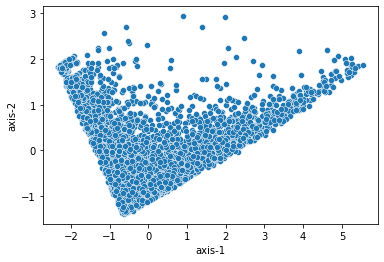

In [32]:
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])
components = pipeline.fit_transform(rfm_table_cleaned)
round(pipeline[1].explained_variance_ratio_[0],2)

In [ ]:
rfm_table_processed = pd.DataFrame(components, columns=['axis-1', 'axis-2'])

In [ ]:
# Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Попробуем разделить это пространство главных компонент на сегменты. 

### Задание 5.4

3.3. Метрики и оценка: количественная оценка качества прогнозов - https://scikit-learn.org/stable/modules/model_evaluation.html

#### Попробуем воспользоваться методом -- k-means. 

Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


2 0.5002407232117708
3 0.5241581600199577
4 0.4976514664024743
5 0.4547797106984532
6 0.44776808673466334
7 0.4217403447570262
8 0.41922113632406366
9 0.4095413132073667
10 0.3977005115422121


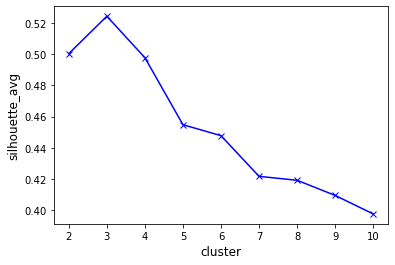

In [33]:
silhouette_avgs = []
for i in range(2, 11):
    kmeans = cluster.KMeans(n_clusters=i, random_state = 42)
    kmeans.fit(rfm_table_processed)
    cluster_labels = kmeans.predict(rfm_table_processed)
    silhouette_avg = metrics.silhouette_score(rfm_table_processed, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    print(i, silhouette_avg)

plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette_avg", fontsize=12)
plt.plot([i for i in range(2, 11)], silhouette_avgs, 'xb-');

In [26]:
model = cluster.KMeans(n_clusters=3, random_state=42)
model.fit(rfm_table_processed)
round(model.inertia_,2)

# 2776.98

2776.98

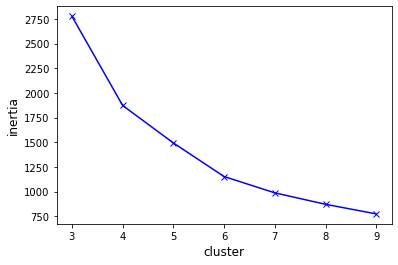

In [32]:
def get_inertia(cluster_num, X):
    k_means =  cluster.KMeans(n_clusters=cluster_num, random_state=42)
    k_means.fit(X)
    inertia = k_means.inertia_
    return inertia
 
inertia = []
for cluster_num in range(3, 10):
    inertia.append(get_inertia(cluster_num, rfm_table_processed))
 
plt.xlabel("cluster", fontsize=12)
plt.ylabel("inertia", fontsize=12)
plt.plot([i for i in range(3, 10)], inertia, 'xb-')

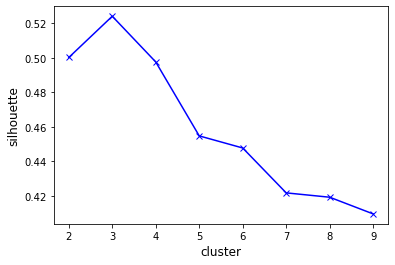

In [33]:
def get_silhouette(cluster_num, df):
    k_means =  cluster.KMeans(n_clusters=cluster_num, random_state=42)
    k_means.fit(df)
    silhouette = silhouette_score(df, k_means.labels_, metric='euclidean')
    return silhouette
from sklearn.metrics import silhouette_score
silhouettes = []
for i in range(2, 10):
    silhouettes.append(get_silhouette(i ,rfm_table_processed))
    
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 10)], silhouettes, 'xb-')

* sklearn.mixture.GaussianMixture -- https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [36]:
k_means =  cluster.KMeans(n_clusters=3, random_state=42)
k_means.fit(rfm_table_processed)
silhouette_score(rfm_table_processed, k_means.labels_, metric='euclidean')

# 0.5241581600199577

0.5241581600199577

### Задание 5.5
Теперь возьмём EM-алгоритм.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


2 0.34242024282886824
3 0.4354538255348205
4 0.3494231540203295
5 0.24673861511098866
6 0.2667070102711961
7 0.20757339631451327
8 0.18985298671397546
9 0.1652121730134772
10 0.1039240759865995


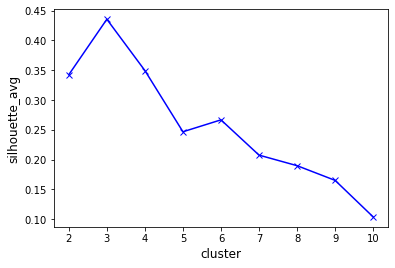

In [34]:
silhouette_avgs = []
for i in range(2, 11):
    em = mixture.GaussianMixture(n_components=i, random_state = 42)
    em.fit(rfm_table_processed)
    cluster_labels = em.predict(rfm_table_processed)
    silhouette_avg = metrics.silhouette_score(rfm_table_processed, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    print(i, silhouette_avg)

plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette_avg", fontsize=12)
plt.plot([i for i in range(2, 11)], silhouette_avgs, 'xb-');

**sklearn.mixture.GaussianMixture** --   https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [42]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=3, random_state=42)
predictions = model.fit_predict(rfm_table_processed)
np.unique(predictions, return_counts=True)

(array([0, 1, 2], dtype=int64), array([1693, 1310, 1042], dtype=int64))

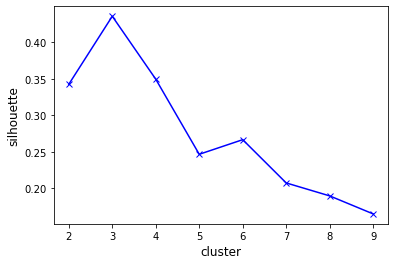

In [47]:
def get_silhouette(cluster_num, df):
    EM_model =  GaussianMixture(n_components=cluster_num, random_state=42)
    EM_model.fit(df)
    labels = EM_model.predict(df)
    silhouette = silhouette_score(df, labels, metric='euclidean')
    return silhouette
from sklearn.metrics import silhouette_score
silhouettes = []
for i in range(2, 10):
    silhouettes.append(get_silhouette(i ,rfm_table_processed))
    
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 10)], silhouettes, 'xb-')

In [48]:
round(silhouette_score(rfm_table_processed, predictions, metric='euclidean'), 2)

0.44

### Задание 5.6
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [35]:
model = cluster.KMeans(init='k-means++', n_clusters = 3, random_state=42)
model.fit(rfm_table_processed)

labels = pd.Series(model.labels_.astype('str'), index=rfm_table_processed.index)
display(labels.value_counts())

# 2    2269
# 0     999
# 1     776
# dtype: int64

0    2268
2    1001
1     776
dtype: int64

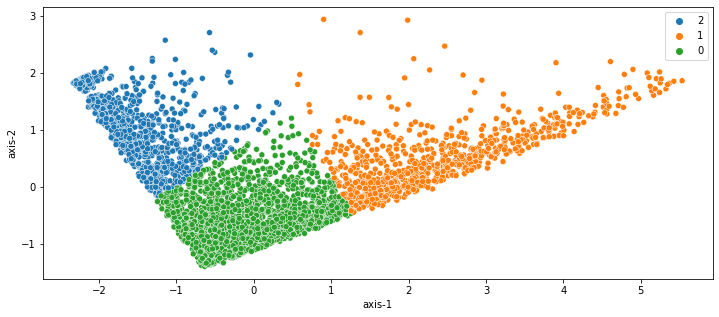

In [36]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
);

In [56]:
model = cluster.KMeans(n_clusters=3, random_state=42)
model.fit(rfm_table_processed)
labels = model.labels_
rfm_table_processed.loc[:, 'label'] = model.labels_
rfm_table_processed.label.value_counts()

# 2    2269
# 0     999
# 1     776
# Name: label, dtype: int64

0    2268
2    1001
1     776
Name: label, dtype: int64

<AxesSubplot:xlabel='axis-1', ylabel='axis-2'>

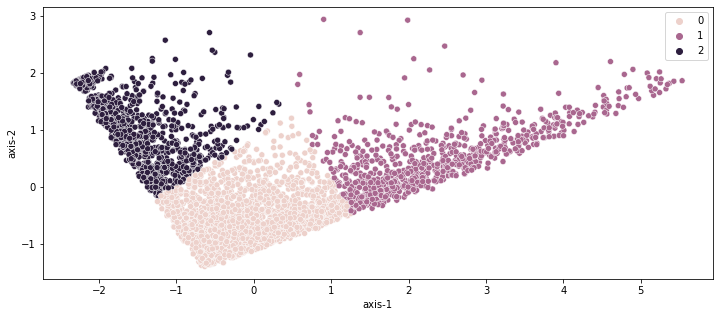

In [57]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
)

Визуализируем результаты кластеризации:

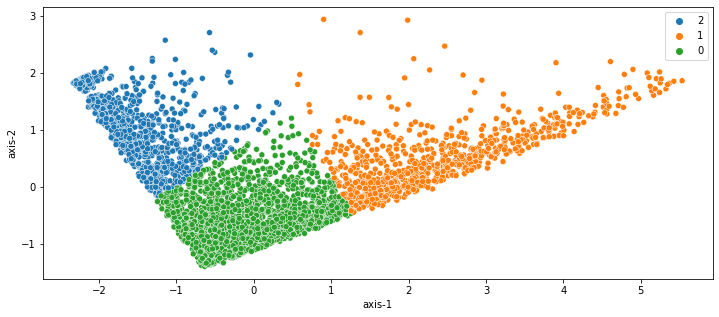

In [37]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
);

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

### Задание 5.7

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чему равно максимальное среднее значение признака Frequency в полученной таблице? Ответ округлите до целого числа.

In [128]:
clustered = rfm_table_cleaned.groupby(labels)[['Recency', 'Frequency', 'Monetary']].mean()
clustered

Recency  Frequency     Monetary
0   51.111111   2.328924   659.877597
1   31.943299   7.068299  2657.746997
2  253.283716   1.405594   386.598472

In [129]:
!pip install openpyxl

In [38]:
cluster_grouped = rfm_table_cleaned.groupby(labels).mean()
display(cluster_grouped.style.background_gradient(cmap='coolwarm'))

#     Recency	Frequency	Monetary
# 0	253.474474	1.403403	386.277297
# 1	31.943299	7.068299	2657.746997
# 2	51.221684	2.329220	660.068947

### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — **Radar Chart -(полярная, или лепестковая, диаграмма).**- Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле - **graph_objects - библиотеки plotly - есть встроенная функция - *Scatterpolar*,** -https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatterpolar.html - которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: **grouped_data** — сгруппированные по кластерам характеристики объектов (клиентов), **n_clusters** — количество кластеров. 

#### import plotly.express as px - : -  высокоуровневый интерфейс для визуализации данных - https://plotly.com/python-api-reference/plotly.express.html#px

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

#### Шпаргалка по визуализации данных в Python с помощью Plotly - https://habr.com/ru/articles/502958/

In [39]:
import plotly.express as px

In [40]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    

Теперь у нас есть удобный инструмент для анализа профиля кластеров. Давайте воспользуемся им.


### Задание 5.8

Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

Описание кластера:
* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


In [48]:
# код не работает

# plot_cluster_profile(cluster_grouped, n_clusters=3)

plot_cluster_profile(cluster_grouped, n_clusters=3)

In [ ]:
plot_cluster_profile(clustered, model.n_clusters)

### Задание 5.8

Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

A - Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.

1 --  верно 

B - Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».

2 --  верно 

C - Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

0 --  верно 

### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

### Задание 6.1
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Создайте pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучите ваш pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и примените к ней трансформацию.

Чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE? Ответ округлите до двух знаков после точки-разделителя.

**Примечание:**
Напомним, что дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.



In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

pipeline_preprocessing = Pipeline(
    steps=[
        ('scaler', preprocessing.StandardScaler()),
        ('dimension', manifold.TSNE(n_components=2, perplexity=50.0, random_state=100))
    ]
)
rfm_table_processed = pipeline_preprocessing.fit_transform(rfm_table_cleaned)
rfm_table_processed = pd.DataFrame(rfm_table_processed, columns=['axis-1', 'axis-2'], index=rfm_table_cleaned.index)
print(round(pipeline_preprocessing['dimension'].kl_divergence_, 2))

# 0.55

0.53


In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline


pipeline = Pipeline([('scaler', StandardScaler()), ('t-SNE', TSNE(n_components=2, perplexity=50, random_state=100))])
components = pipeline.fit_transform(rfm_table_cleaned)
round(pipeline[1].kl_divergence_,2)

# 0.55

0.53

In [56]:
rfm_table_processed = pd.DataFrame(components, columns=['axis-1', 'axis-2'])

Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


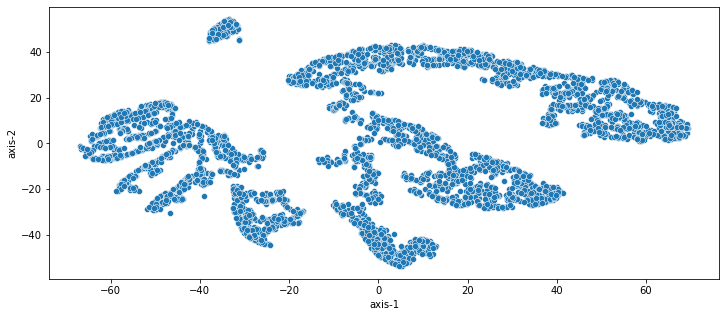

In [57]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### Задание 6.2
Попробуем воспользоваться методом k-means. 
Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять? -- 8

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя. -- 0.52



3 0.42684653
4 0.50110614
5 0.49776223
6 0.4825089
7 0.50102085
8 0.5048991


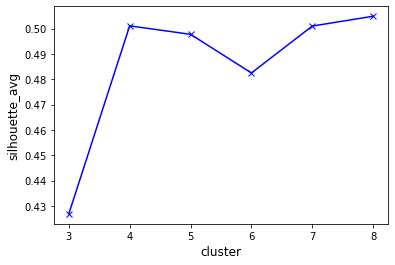

In [58]:
silhouette_avgs = []
for i in range(3, 9):
    kmeans = cluster.KMeans(n_clusters=i, random_state = 42)
    kmeans.fit(rfm_table_processed)
    cluster_labels = kmeans.predict(rfm_table_processed)
    silhouette_avg = metrics.silhouette_score(rfm_table_processed, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    print(i, silhouette_avg)

plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette_avg", fontsize=12)
plt.plot([i for i in range(3, 9)], silhouette_avgs, 'xb-');

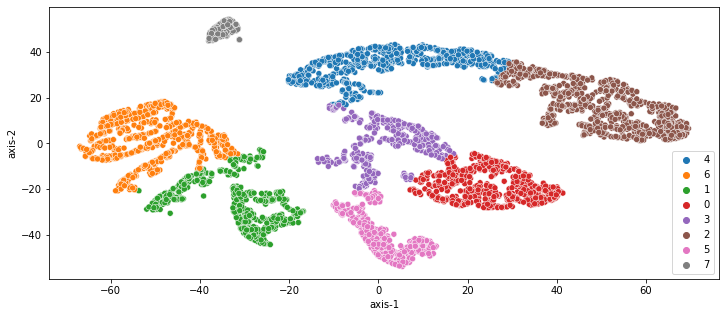

In [59]:
km = cluster.KMeans(n_clusters=8, random_state=42)
km.fit(rfm_table_processed)
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=km.predict(rfm_table_processed).astype('str'));

In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(rfm_table_processed)
round(model.inertia_,2)

# 2524448.75

In [ ]:
def get_silhouette(cluster_num, df):
    k_means =  KMeans(n_clusters=cluster_num, random_state=42)
    k_means.fit(df)
    silhouette = silhouette_score(df, k_means.labels_, metric='euclidean')
    return silhouette
from sklearn.metrics import silhouette_score
silhouettes = []
for i in range(3, 9):
    silhouettes.append(get_silhouette(i ,rfm_table_processed))
    
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(3, 9)], silhouettes, 'xb-')

In [ ]:
silhouettes

# [0.4239861, 0.46087533, 0.50164825, 0.5037763, 0.4884254, 0.5093719]

### Задание 6.3
Попробуем воспользоваться EM-алгоритом. 

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять? -- 4

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя. -- 0.50

3 0.4235596
4 0.4845145
5 0.38363665
6 0.41444787
7 0.4290064
8 0.451232


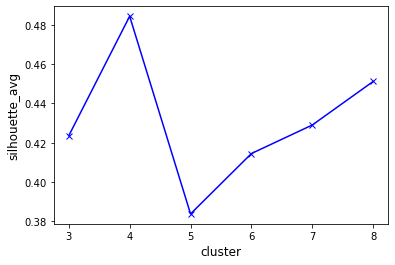

In [61]:
silhouette_avgs = []
for i in range(3, 9):
    em = mixture.GaussianMixture(n_components=i, random_state = 42)
    em.fit(rfm_table_processed)
    cluster_labels = em.predict(rfm_table_processed)
    silhouette_avg = metrics.silhouette_score(rfm_table_processed, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    print(i, silhouette_avg)

plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette_avg", fontsize=12)
plt.plot([i for i in range(3, 9)], silhouette_avgs, 'xb-');

# 3 0.41828558
# 4 0.44163734
# 5 0.49610046
# 6 0.44700232
# 7 0.46414647
# 8 0.47677422

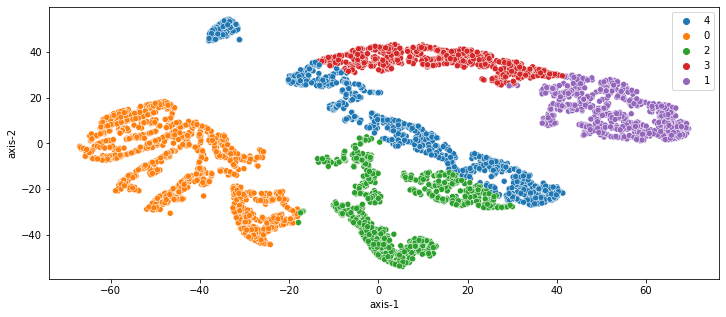

In [62]:
em = mixture.GaussianMixture(n_components=5, random_state=42)
em.fit(rfm_table_processed)
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=em.predict(rfm_table_processed).astype('str'));

In [ ]:
model = GaussianMixture(n_components=3, random_state=42)
predictions = model.fit_predict(rfm_table_processed)
np.unique(predictions, return_counts=True)
# (array([0, 1, 2], dtype=int64), array([1262, 1718, 1064], dtype=int64))

In [ ]:
silhouettes

# [0.4155206696056797,
#  0.44007811564272153,
#  0.47169861129414586,
#  0.5066756888005087,
#  0.454130002461182,
#  0.4805787238658699]

### Задание 6.4
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберите оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 

Все параметры, за исключением числа кластеров, оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



2 0.37576658
3 0.39882943
4 0.4370611
5 0.46710318
6 0.46136737
7 0.48930192
8 0.48751378


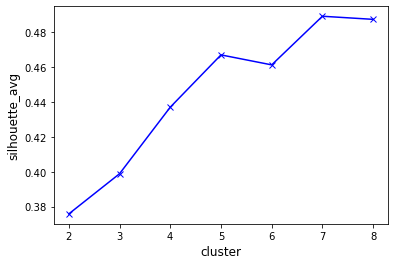

In [63]:
silhouette_avgs = []
for i in range(2, 9):
    ag = cluster.AgglomerativeClustering(n_clusters=i)
    ag.fit(rfm_table_processed)
    cluster_labels = ag.labels_
    silhouette_avg = metrics.silhouette_score(rfm_table_processed, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    print(i, silhouette_avg)

plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette_avg", fontsize=12)
plt.plot([i for i in range(2, 9)], silhouette_avgs, 'xb-');

# 2 0.40549886
# 3 0.38463378
# 4 0.43942398
# 5 0.48902467
# 6 0.50516087
# 7 0.51657736
# 8 0.5058679

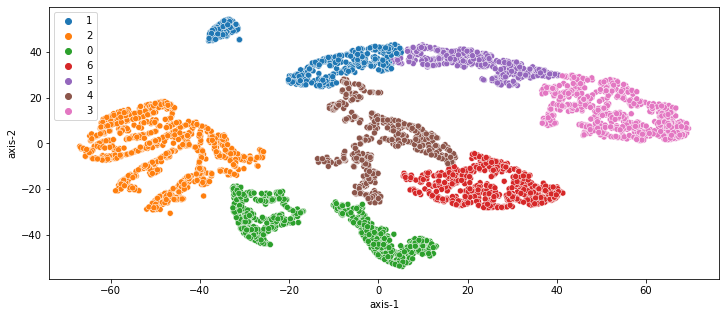

In [64]:
ag = cluster.AgglomerativeClustering(n_clusters=7)
ag.fit(rfm_table_processed)
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=ag.labels_.astype('str'));

In [ ]:
model = AgglomerativeClustering(n_clusters=3)
model.fit(rfm_table_processed)

In [ ]:
# Moto

def get_silhouette(cluster_num, df):
    Agg_model =  AgglomerativeClustering(n_clusters=cluster_num)
    Agg_model.fit(df)
    silhouette = silhouette_score(df, Agg_model.labels_, metric='euclidean')
    return silhouette
from sklearn.metrics import silhouette_score
silhouettes = []
for i in range(2, 9):
    silhouettes.append(get_silhouette(i ,rfm_table_processed))
    
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 9)], silhouettes, 'xb-')

In [ ]:
silhouettes

# [0.40549886,
#  0.38463378,
#  0.43942398,
#  0.48902467,
#  0.50516087,
#  0.51657736,
#  0.5058679]

### Задание 6.5
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture
* AgglomerativeClustering


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [65]:
model = cluster.AgglomerativeClustering(n_clusters=7)
model.fit(rfm_table_processed)

labels = pd.Series(model.labels_.astype('str'), index=rfm_table_processed.index)
display(labels.value_counts())

# 1    904
# 2    725
# 0    719
# 4    651
# 3    508
# 5    423
# 6    114
# dtype: int64

2    908
0    648
3    648
6    542
4    515
1    441
5    343
dtype: int64

In [ ]:
model = AgglomerativeClustering(n_clusters=7)
model.fit(rfm_table_processed)
labels = model.labels_
rfm_table_processed.loc[:, 'label'] = model.labels_
rfm_table_processed.label.value_counts()

# 1    904
# 2    725
# 0    719
# 4    651
# 3    508
# 5    423
# 6    114
# Name: label, dtype: int64

Визуализируем результаты кластеризации:

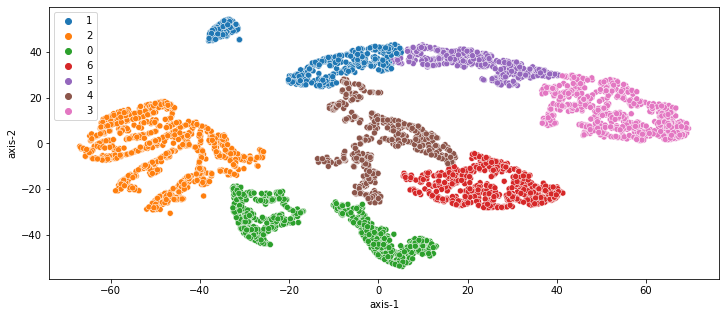

In [66]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=model.labels_.astype('str'));


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


### Задание 6.6
Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков. Для наглядности округлите все значения в столбцах до целого числа.

Чему равно максимальное среднее значение признака Recency в полученной таблице? Ответ округлите до целого числа.# Задание 6.6

Для составления профиля кластеров нам 

In [71]:
cluster_grouped = rfm_table_cleaned.groupby(labels).mean().round(0)
display(cluster_grouped.style.background_gradient(cmap='coolwarm'))

In [ ]:
 	Recency	     Frequency	 Monetary
0	44.000000	3.000000	967.000000
1	33.000000	7.000000	2418.000000
2	169.000000	2.000000	546.000000
3	38.000000	2.000000	547.000000
4	46.000000	1.000000	331.000000
5	283.000000	1.000000	351.000000
6	365.000000	1.000000	236.000000

In [91]:
clustered_grouped = rfm_table_cleaned.groupby(labels)[['Recency', 'Frequency', 'Monetary']].mean()
display(clustered_grouped)

Empty DataFrame
Columns: [Recency, Frequency, Monetary]
Index: []

In [ ]:
    Recency	    Frequency	Monetary
0	44.394993	3.468707	967.386912
1	32.734513	6.803097	2418.338960
2	168.929655	1.764138	545.556110
3	37.950787	2.000000	546.600571
4	45.637481	1.000000	331.322043
5	282.728132	1.094563	351.127565
6	365.456140	1.043860	235.531930

In [ ]:
clustered_grouped = rfm_table_cleaned.groupby(labels)[['Recency', 'Frequency', 'Monetary']].mean()
display(clustered_grouped)

### Задание 6.7
Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая. -- 1
* Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты. --- 4
* Кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных». --- 2
* Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад. --- 5
* Кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. -- 0 
* Кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались. --- 6
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад. --- 3

In [ ]:
# plot_cluster_profile(cluster_grouped, n_clusters=7)

plot_cluster_profile(cluster_grouped, n_clusters=7)

In [ ]:
plot_cluster_profile(clustered, model.n_clusters)

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вы, вероятно, скажете: «Воспользоваться методом predict()!»

Верно, однако всё не так просто.

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

### Задание 7.1

Разделите исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмите число 42.

Сколько клиентов попали в тестовую выборку?

In [73]:
from sklearn.model_selection import train_test_split

In [76]:
# Создаем матрицу наблюдений X и вектор правильных ответов y
X = rfm_table_cleaned #очищенная RFM-таблица
y = labels #метки кластеров, предсказанные ранее

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42, test_size=0.2)
X_test.shape[0]

809

Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут (можете убедиться в этом самостоятельно, обучив модель логистической регрессии на тренировочной выборке и оценив качество на тестовой).

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы. 


In [83]:
# import numpy as np
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
metrics.accuracy_score(y_test, logreg.predict(X_test))

# 0.4400494437577256

0.43016069221260816

### Задание 7.2
Начнём со случайного леса. С помощью GridSearchCV организуйте перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в случайном лесу?

2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
gs = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5
)

gs.fit(X_train, y_train)
gs.best_estimator_

# max_depth - должно быть = 114

RandomForestClassifier(max_depth=12, n_estimators=500, random_state=42)

In [88]:
rf = ensemble.RandomForestClassifier(
    max_depth=13,
    random_state=42
)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
metrics.accuracy_score(y_test_pred, y_test)

0.9864029666254636

In [87]:
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=42, #генератор случайных чисел
    ), 
    scoring='accuracy',
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)
print('Accuracy на тестовом наборе: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Accuracy на тестовом наборе: 0.986
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 500}


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### Задание 7.3
С помощью GridSearchCV организуйте перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5. 

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в градиентном бустинге?
Ответ: 6
2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



**max_depth =**  6

**accuracy :** 0.982

In [90]:
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
gs = model_selection.GridSearchCV(
    estimator=ensemble.GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5
)

gs.fit(X_train, y_train)
gs.best_estimator_

GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)

In [91]:
gbc = ensemble.GradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.01,
    n_estimators=500,
    random_state=42
)
gbc.fit(X_train, y_train)
y_test_pred = gbc.predict(X_test)
metrics.accuracy_score(y_test_pred, y_test)

0.9814585908529048

Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.